In [1]:
import pandas as pd
from drn_interactions.config import Config
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from drn_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.io import load_derived_generic
from drn_interactions.config import Config, ExperimentInfo
from tqdm import tqdm
import numpy as np
import warnings

dd = Config.derived_data_dir / "corrs"
dd.mkdir(exist_ok=True)

In [26]:
from ssri_interactions.transforms.graph import GraphTransformer
from ssri_interactions.io import load_distances


def add_meta_pairwise(df_edge, comb_col="comb", value_coll="corr"):
    neuron_types = load_derived_generic("neuron_types.csv")
    neurons = neuron_types[["neuron_id", "neuron_type"]].dropna().neuron_id.unique()
    df_rsc = (
        df_edge
        .drop("comb", axis=1)
        .assign(neuron_1=lambda x: x.neuron_1.astype(int))
        .assign(neuron_2=lambda x: x.neuron_2.astype(int))
        .query("neuron_1 in @neurons and neuron_2 in @neurons")
        .copy()
    )
    df_distance = load_distances().rename(columns=dict(neuron1="neuron_1", neuron2="neuron_2"))
    g_transformer = GraphTransformer(
        relabel_nodes=True,
        weight_attr="corr",
        neuron_type_col="neuron_type",
        distance_source_col="neuron_1",
        distance_target_col="neuron_2",
        df_distance=df_distance,
    )

    df_rsc = g_transformer._add_id_comb_col(
        df_rsc,
        source_col="neuron_1",
        target_col="neuron_2",
        comb_col_name="comb_id",
    )
    
    df_rsc = g_transformer._add_neuron_type_comb_col(
        df_rsc, 
        df_neuron_types=neuron_types,
        source_col="neuron_1", 
        target_col="neuron_2"
        )    
    df_distance = g_transformer._add_id_comb_col(
        df_distance,
        source_col="neuron_1",
        target_col="neuron_2",
        comb_col_name="comb_id",
    )
    
    thresh = (
        df_rsc.query("shuffle==True")
        .groupby(["nt_comb", "bin_width", "block"])[value_coll]
        .apply(lambda x: np.quantile(a=x.dropna().abs(), q=0.99))
        .to_dict()
    )
    df_rsc = (
        df_rsc.groupby(["nt_comb", "bin_width", "block"])
        .apply(lambda x: thresh[x.name])
        .to_frame("thresh")
        .reset_index()
        .merge(df_rsc)
        .assign(sig=lambda x: x[value_coll].abs() > x["thresh"])
    )
    # print(df_rsc.info())
    # print(df_distance.info())

    # return df_rsc.merge(df_distance[["comb_id", "distance"]])
    return df_rsc

def add_meta_single(df_node):
    neuron_types = load_derived_generic("neuron_types.csv")
    df_node = df_node.merge(
        neuron_types[
            ["neuron_id", "session_name", "neuron_type"]
        ].drop_duplicates()
    )
    thresh = (
        df_node.query("shuffle==True")
        .groupby(["neuron_type", "bin_width", "block"])["cc"]
        .apply(lambda x: np.quantile(a=x.dropna().abs(), q=0.95))
        .to_dict()
    )
    df_node = (
        df_node.groupby(["neuron_type", "bin_width", "block"])
        .apply(lambda x: thresh[x.name])
        .to_frame("thresh")
        .reset_index()
        .merge(df_node)
        .assign(sig=lambda x: x["cc"].abs() > x["thresh"])
    )
    
    return df_node


In [27]:
# neuron_types = load_derived_generic("neuron_types.csv")
# sessions = ExperimentInfo.foot_shock_sessions_10min
# res_corr = []
# res_pcorr = []
# res_pcup = []
# bin_widths = [0.05, 0.1, 0.5, 1]

# loader_fac = lambda bin_width, block, shuffle: BaseShockSlowInteractionsLoader(
#     session_name=sessions[0], bin_width=bin_width, block=block, shuffle=shuffle
# )
# preprocessor_fac = lambda: InteractionsPreprocessor(
#     z=True, minmax=False, gaussian_sigma=None
# )
# corr_fac = lambda: PairwiseCorr()
# pcorr_fac = lambda: PairwisePartialCorr()
# pcup_fac = lambda: PopulationCoupling()

# runner_fac = lambda bin_width, shuffle, block: InteractionsRunner(
#     loader=loader_fac(bin_width, shuffle=shuffle, block=block),
#     preprocessor=preprocessor_fac(),
#     pcup=pcup_fac(),
#     corr=corr_fac(),
#     pcorr=pcorr_fac(),
# )


# for shuffle in (True, False):
#     for bin_width in bin_widths:
#         for block in ("pre", "base_shock"):
#             runner = runner_fac(bin_width=bin_width, shuffle=shuffle, block=block)
#             res_pcorr.append(runner.run_pcorr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle, block=block))
#             res_corr.append(runner.run_corr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle, block=block))
#             res_pcup.append(runner.run_pcup_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle, block=block))

df_corr = pd.concat(res_corr).reset_index(drop=True).pipe(add_meta_pairwise, value_coll="corr")
df_pcorr = pd.concat(res_pcorr).reset_index(drop=True).pipe(add_meta_pairwise, value_coll="pcorr")
df_pcup = pd.concat(res_pcup).reset_index(drop=True).pipe(add_meta_single)


df_corr.to_parquet(dd / "fs - corr.parquet", index=False)
df_pcorr.to_parquet(dd / "fs - pcorr.parquet", index=False)
df_pcup.to_parquet(dd / "fs - pcup.parquet", index=False)

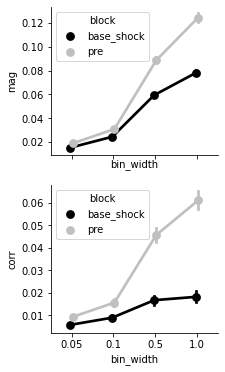

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK

sns.set_palette(PAL_GREY_BLACK)
df_corr["mag"] = df_corr["corr"].abs()
df_pcorr["mag"] = df_pcorr["pcorr"].abs()
df_pcup["mag"] = df_pcup["cc"].abs()


f = plt.figure(figsize=(3, 6))
ax = f.subplots(2, 1, sharex=True)

sns.pointplot(data=df_corr, x="bin_width", y="corr", hue="block", dodge=True, ax=ax[1])
sns.pointplot(data=df_corr, x="bin_width", y="mag", hue="block", dodge=True, ax=ax[0])

sns.despine(fig=f)

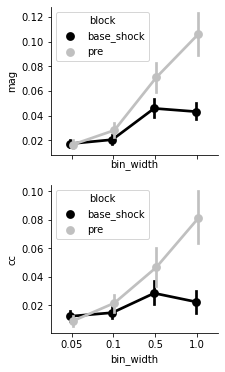

In [32]:
f = plt.figure(figsize=(3, 6))
ax = f.subplots(2, 1, sharex=True)

sns.pointplot(data=df_pcup, x="bin_width", y="cc", hue="block", dodge=True, ax=ax[1])
sns.pointplot(data=df_pcup, x="bin_width", y="mag", hue="block", dodge=True, ax=ax[0])

sns.despine(fig=f)

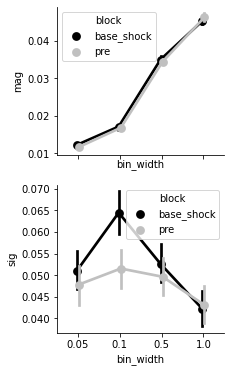

In [33]:
f = plt.figure(figsize=(3, 6))
ax = f.subplots(2, 1, sharex=True)

sns.pointplot(data=df_pcorr, x="bin_width", y="sig", hue="block", dodge=True, ax=ax[1])
sns.pointplot(data=df_pcorr, x="bin_width", y="mag", hue="block", dodge=True, ax=ax[0])

sns.despine(fig=f)